<a href="https://colab.research.google.com/github/Weverton-Vitor/segmentation-cell-unet/blob/main/semantic_segmentation_of_cells_on_microscope_images_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Cells On Microscope Images using UNet

## 0. Imports and install packeges

In [1]:
!pip install torchinfo

In [2]:
import os
import shutil
import zipfile
import random
import json
from typing import Tuple

import numpy as np
import skimage
import tifffile

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision.datasets import CocoDetection
from torchvision import datasets, transforms
from torchvision import datasets, transforms
import pycocotools.mask as coco_mask

from torchinfo import summary

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches


## 1. Get the dataset

### 1.1 Donwload images

In [3]:
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip

--2024-02-14 00:41:31--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 52.219.170.130, 3.5.136.135, 3.5.136.21, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|52.219.170.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1241715651 (1.2G) [application/zip]
Saving to: ‘images.zip.3’

images.zip.3        100%[===================>]   1.16G  26.2MB/s    in 46s     

2024-02-14 00:42:17 (25.6 MB/s) - ‘images.zip.3’ saved [1241715651/1241715651]



In [4]:
dataset_path_zip = '/content/images.zip'
zipfile.ZipFile(dataset_path_zip).extractall('/content/')

In [5]:
# 5% of the train annotations
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/2_train5percent.json

# Validation and Test annotations
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json

--2024-02-14 00:42:34--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/2_train5percent.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 52.219.75.220, 52.219.170.86, 3.5.134.152, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|52.219.75.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27988522 (27M) [application/json]
Saving to: ‘2_train5percent.json.3’

2_train5percent.jso 100%[===================>]  26.69M  15.4MB/s    in 1.7s    

2024-02-14 00:42:36 (15.4 MB/s) - ‘2_train5percent.json.3’ saved [27988522/27988522]

--2024-02-14 00:42:36--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.c

### 1.2 Create custom datasets and Visualizing random images of dataset

In [6]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, root, annFile, transform=None, target_transform=None):
        self.transform = transform
        self.coco_dataset = CocoDetection(root=root, annFile=annFile, target_transform=target_transform)

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, ann = self.coco_dataset[idx]
        w, h = img.size
        mask = Image.fromarray(self.create_mask(w, h, ann).astype('uint8'))
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

    def create_mask(self, width, height, ann):
      # Create an empty mask as a numpy array
      mask_np = np.zeros((height, width), dtype=np.uint16)

      # Counter for the object number
      object_number = 1

      # Extract segmentation polygon
      for annotation in ann:
        for seg in annotation['segmentation']:
            if type(seg) is list:
              # Convert polygons to a binary mask and add it to the main mask
              rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
              mask_np[rr, cc] = object_number
              object_number += 1 #We are assigning each object a unique integer value (labeled mask)

      return mask_np

    def show_random_samples(self, qty: int=5) -> None:
      random_samples = random.sample(range(len(self.coco_dataset)), k=qty)

      fig = plt.figure(figsize=(15, 15))

      for i, sample in enumerate(random_samples):
        fig.add_subplot(1, qty, i+1)
        plt.imshow(self.coco_dataset[sample][0])
        plt.axis('off')

    def show_random_samples_with_annotations_poligons(self, fill_polygons: bool=False) -> None:
      random_samples = random.sample(range(len(self.coco_dataset)), k=4)

      # fig = plt.figure(figsize=(15, 15))
      fig, axs = plt.subplots(2, 2, figsize=(15, 15))

      for idx, ax in enumerate(axs.flat):
        # fig.add_subplot(1, qty, i+1)
        ax.imshow(self.coco_dataset[random_samples[idx]][0])
        ax.axis('off')

        annotations = self.coco_dataset[random_samples[idx]][1]
        for ann in annotations:
          for seg in ann['segmentation']:
            if type(seg) is list:
              poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
              polygon = plt.Polygon(poly, closed=True, edgecolor='g', fill=fill_polygons, facecolor='none')
              ax.add_patch(polygon)


In [7]:
# Train, Val and Test images and annotation paths
train_dataset_image_root_path = '/content/images/livecell_train_val_images'
train_dataset_annotations_root_path = '/content/2_train5percent.json'

val_dataset_image_root_path = '/content/images/livecell_train_val_images'
val_dataset_annotations_root_path = '/content/livecell_coco_val.json'

test_dataset_image_root_path = '/content/images/livecell_test_images'
test_dataset_annotations_root_path = '/content/livecell_coco_test.json'

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [9]:
# Train dataset (only 5%)
train_dataset = CocoSegmentationDataset(root=train_dataset_image_root_path, transform=transform, annFile=train_dataset_annotations_root_path);

loading annotations into memory...
Done (t=1.80s)
creating index...
index created!


In [10]:
val_dataset = CocoSegmentationDataset(root=train_dataset_image_root_path,  transform=transform, annFile=val_dataset_annotations_root_path)

loading annotations into memory...
Done (t=6.15s)
creating index...
index created!


In [11]:
np.asarray(train_dataset[0][0]).shape

(3, 224, 224)

In [12]:
train_dataset[0]

(tensor([[[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.4588, 0.5137, 0.4902],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4980, 0.4471],
          [0.5059, 0.5020, 0.5020,  ..., 0.5216, 0.5294, 0.5255]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.4588, 0.5137, 0.4902],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4980, 0.4471],
          [0.5059, 0.5020, 0.5020,  ..., 0.5216, 0.5294, 0.5255]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ...,

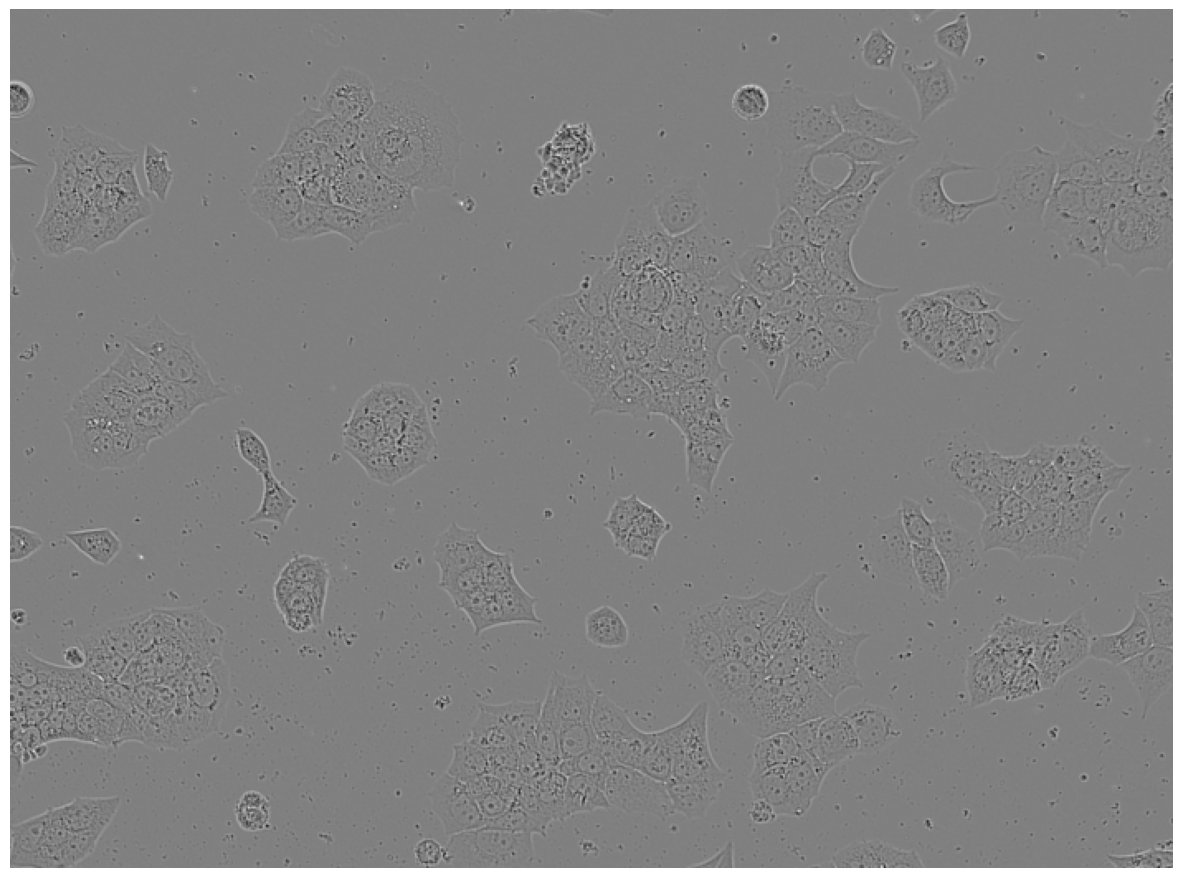

In [13]:
train_dataset.show_random_samples(qty=1)

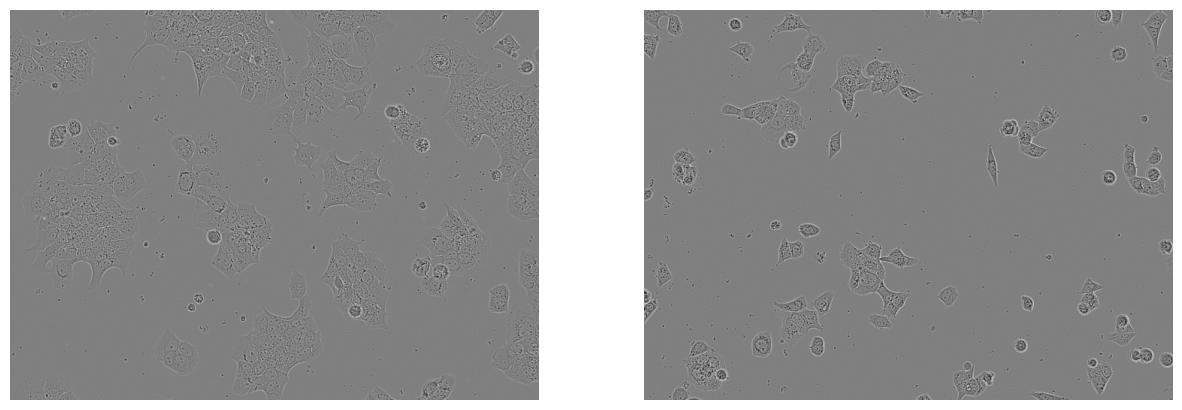

In [14]:
val_dataset.show_random_samples(qty=2)

### 1.3 Visualizing the annotations of a image


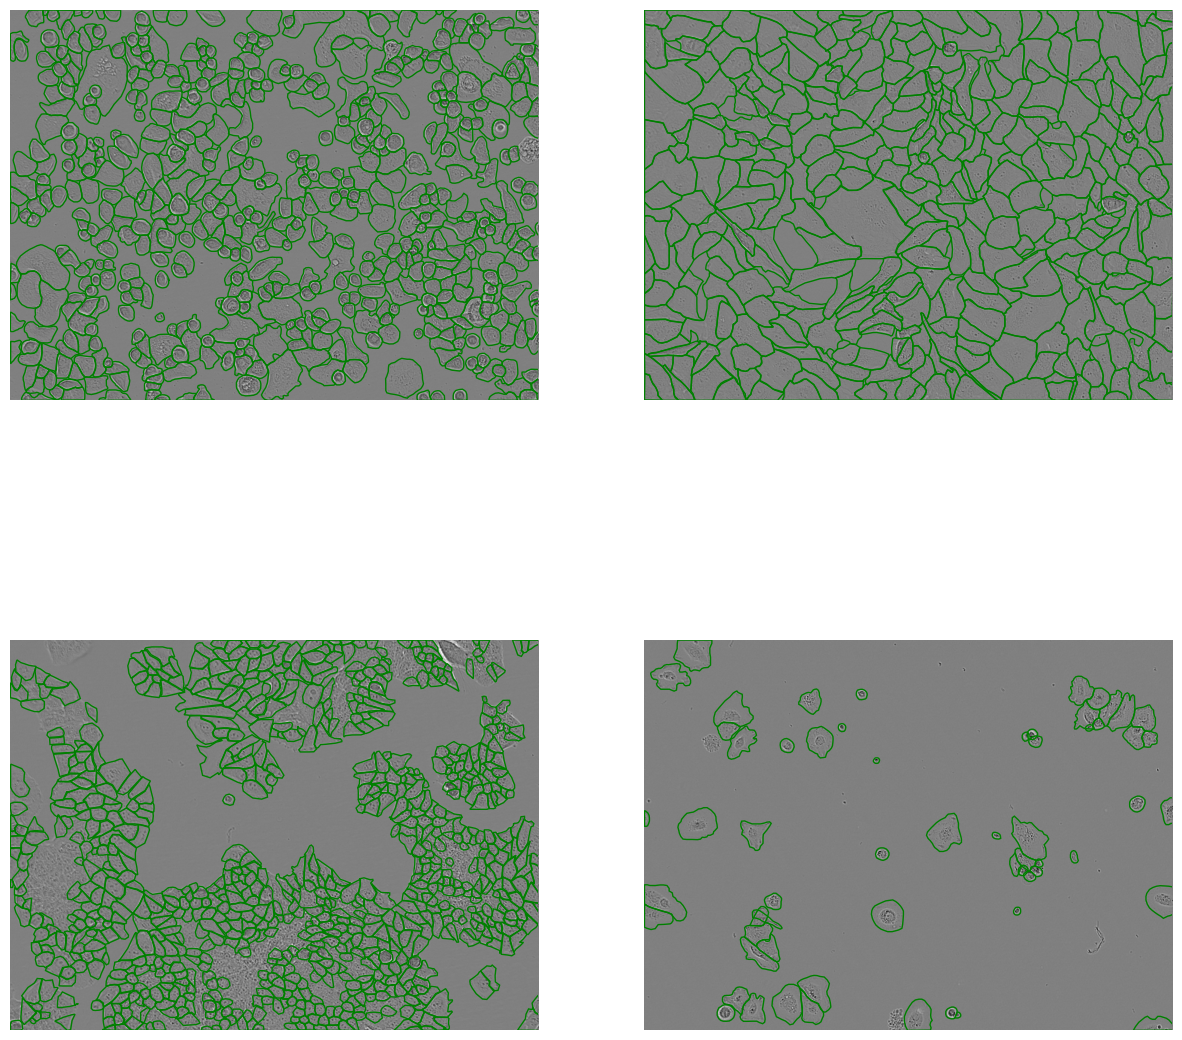

In [15]:
train_dataset.show_random_samples_with_annotations_poligons()

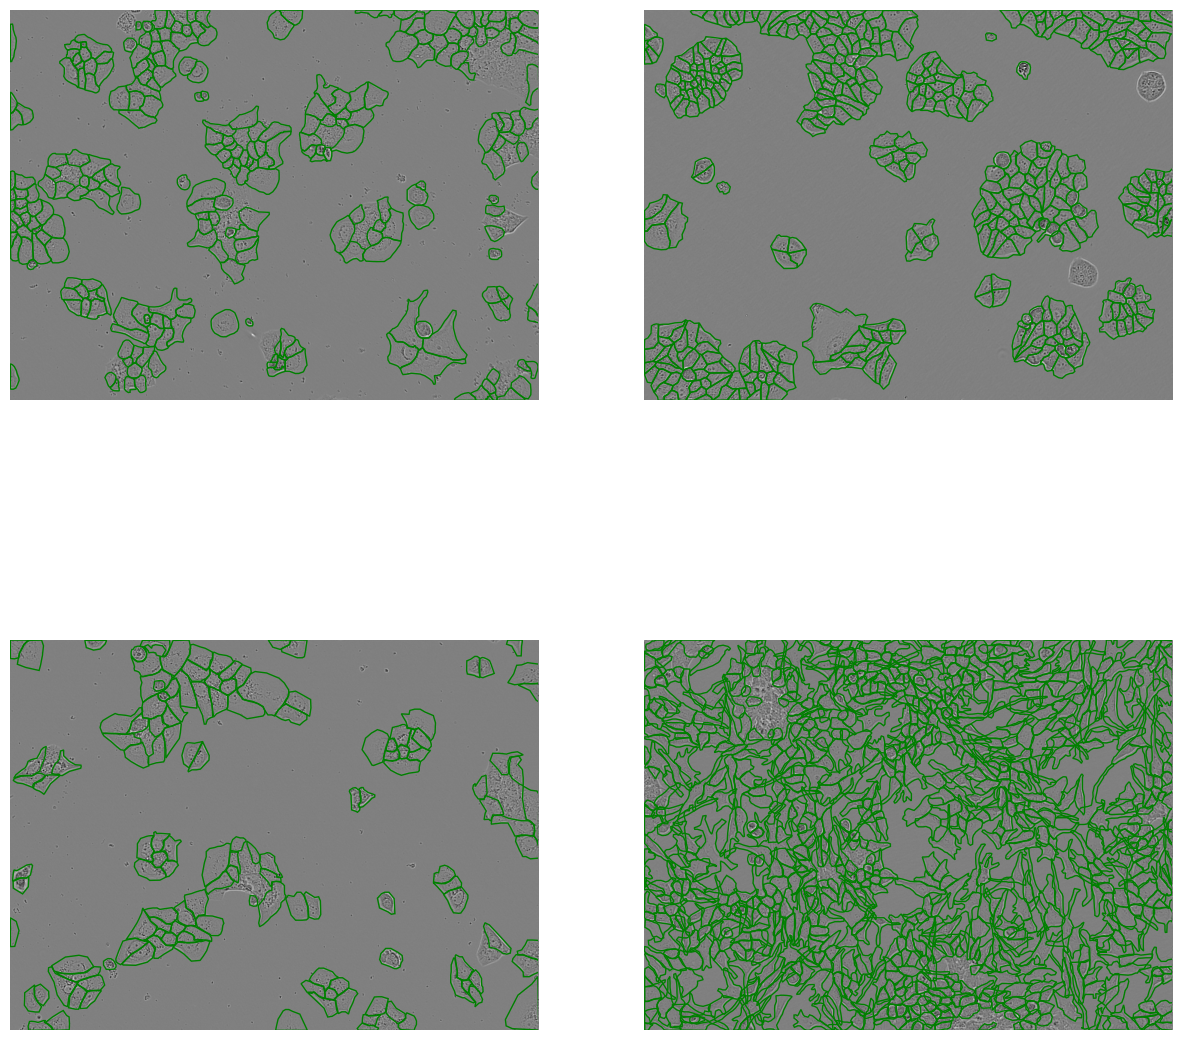

In [16]:
val_dataset.show_random_samples_with_annotations_poligons()

### 1.3 Visualizing the maks segmentation

In [17]:
train_dataset[0]

(tensor([[[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.4588, 0.5137, 0.4902],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4980, 0.4471],
          [0.5059, 0.5020, 0.5020,  ..., 0.5216, 0.5294, 0.5255]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.4588, 0.5137, 0.4902],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4980, 0.4471],
          [0.5059, 0.5020, 0.5020,  ..., 0.5216, 0.5294, 0.5255]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ...,

In [18]:
def show_random_masks(dataset: datasets.CocoDetection, qty: int=5) -> None:
  random_masks = random.sample(range(len(dataset)), k=qty)

  fig = plt.figure(figsize=(15, 15))

  for i, mask in enumerate(random_masks):
    fig.add_subplot(1, qty, i+1)
    plt.imshow(dataset[mask][1].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
  plt.show()

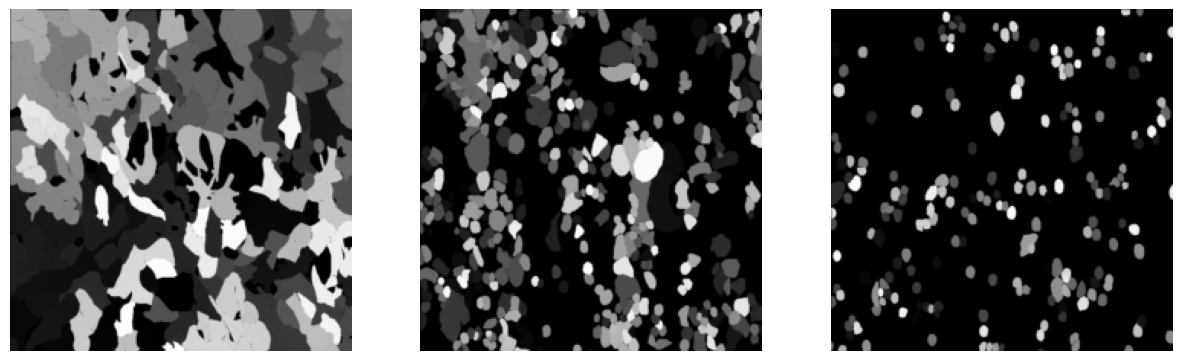

In [19]:
show_random_masks(dataset=train_dataset, qty=3)

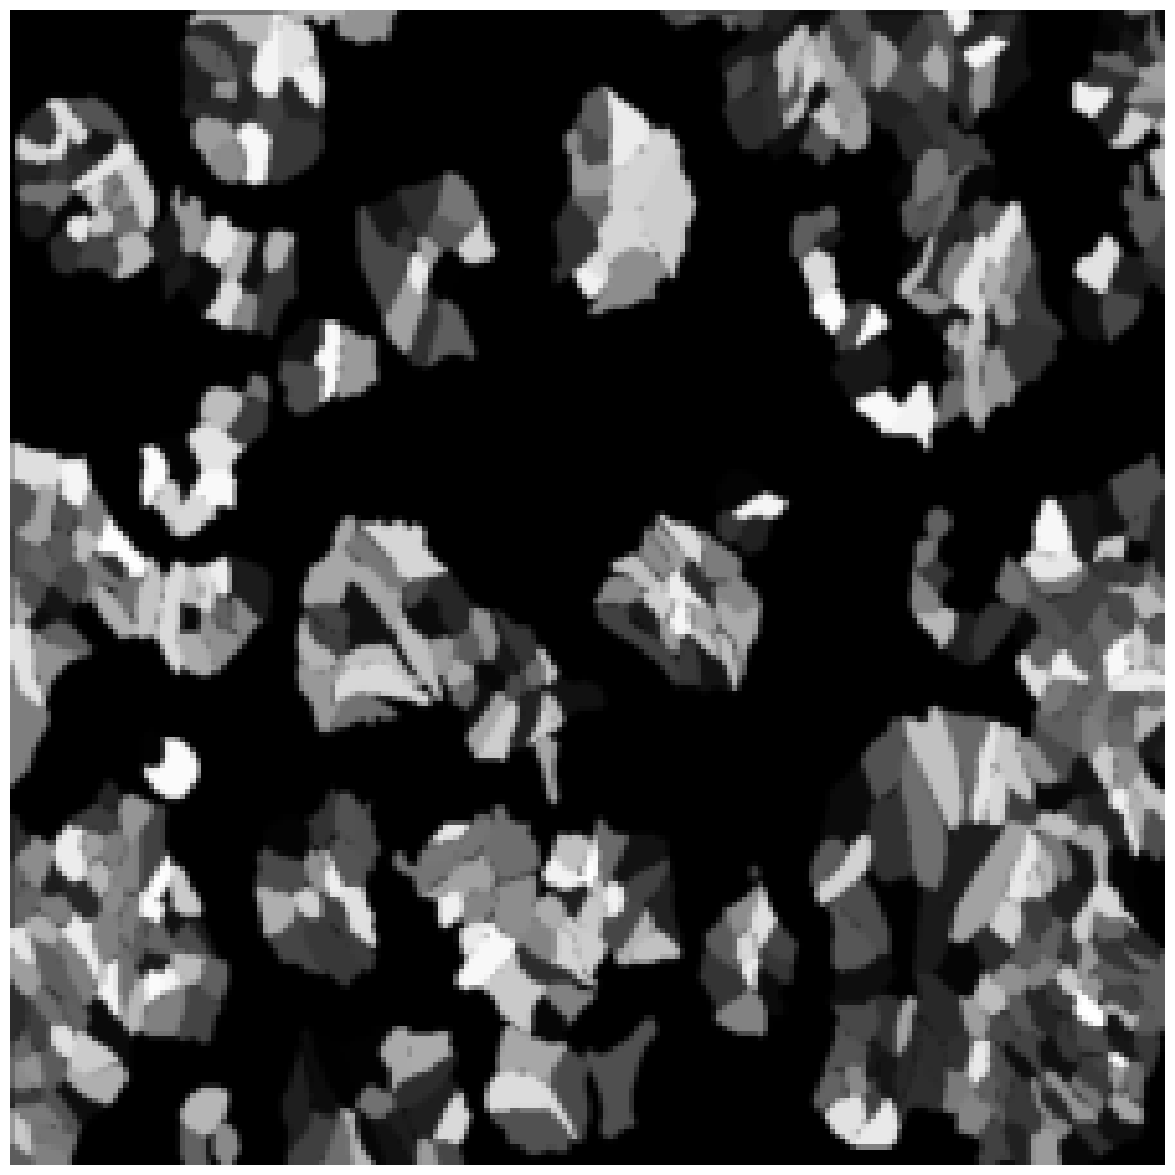

In [20]:
show_random_masks(dataset=val_dataset, qty=1)

### 1.4 Visualizing random images and its respective masks

In [21]:
def show_random_image_and_mask(dataset: datasets.CocoDetection) -> None:
  random_sample = random.choice(range(len(dataset)))

  fig = plt.figure(figsize=(15, 15))

  fig.add_subplot(1, 2, 1)
  plt.imshow(dataset[random_sample][0].permute(1, 2, 0), cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  fig.add_subplot(1, 2, 2)
  plt.imshow(dataset[random_sample][1].permute(1, 2, 0), cmap='gray')
  plt.title('Mask')

  plt.axis('off')
  plt.show()

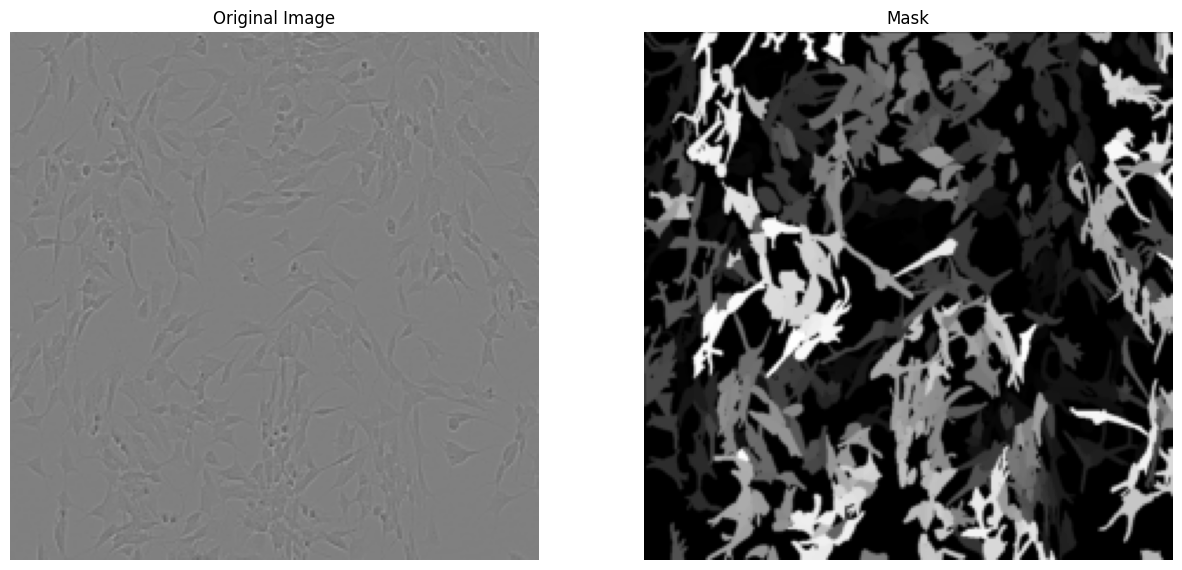

In [22]:
show_random_image_and_mask(train_dataset)

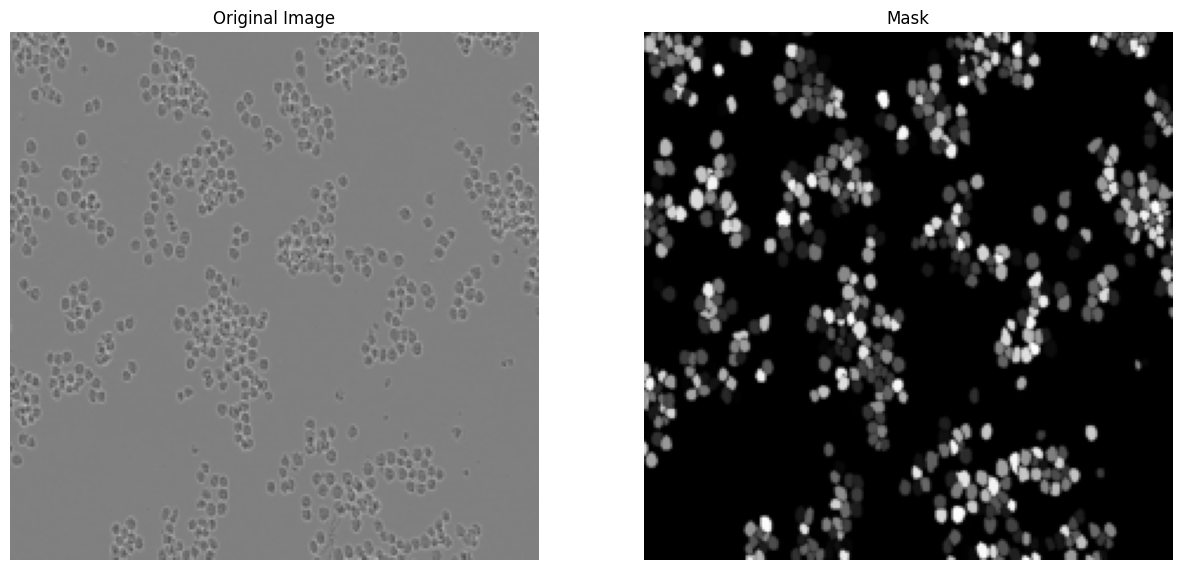

In [23]:
show_random_image_and_mask(val_dataset)

### 1.5 Generate DataLoader and tranforms images with torchvision

#### 1.5.1 Device Agnostic

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 1.5.2 Create DataLoaders

In [25]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=32)

In [26]:
next(iter(train_dataloader))

[tensor([[[[0.5020, 0.5020, 0.5020,  ..., 0.6157, 0.6235, 0.5647],
           [0.4980, 0.5020, 0.5020,  ..., 0.5333, 0.5176, 0.4980],
           [0.5020, 0.5020, 0.5020,  ..., 0.5176, 0.5137, 0.5176],
           ...,
           [0.4980, 0.5098, 0.5569,  ..., 0.5255, 0.5294, 0.5451],
           [0.4667, 0.4824, 0.4902,  ..., 0.5059, 0.5137, 0.5137],
           [0.5294, 0.4784, 0.4863,  ..., 0.4863, 0.4902, 0.4784]],
 
          [[0.5020, 0.5020, 0.5020,  ..., 0.6157, 0.6235, 0.5647],
           [0.4980, 0.5020, 0.5020,  ..., 0.5333, 0.5176, 0.4980],
           [0.5020, 0.5020, 0.5020,  ..., 0.5176, 0.5137, 0.5176],
           ...,
           [0.4980, 0.5098, 0.5569,  ..., 0.5255, 0.5294, 0.5451],
           [0.4667, 0.4824, 0.4902,  ..., 0.5059, 0.5137, 0.5137],
           [0.5294, 0.4784, 0.4863,  ..., 0.4863, 0.4902, 0.4784]],
 
          [[0.5020, 0.5020, 0.5020,  ..., 0.6157, 0.6235, 0.5647],
           [0.4980, 0.5020, 0.5020,  ..., 0.5333, 0.5176, 0.4980],
           [0.5020, 0.50

In [27]:
next(iter(train_dataloader))[0].shape,  next(iter(train_dataloader))[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1, 224, 224]))

## 2. Build Unet

Original Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

![](https://developers.arcgis.com/python/guide/images/unet.png)


### 2.1 Encoder

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*xbG7s8urH-QcsHokMsj85Q.png)

In [42]:
class ConvBlock(nn.Module):
  def __init__(self, in_filters: int=3, out_filters: int=64, kernel_size=(3, 3)):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=in_filters,
                  out_channels=out_filters,
                  kernel_size=kernel_size),
        nn.ReLU(),

        nn.Conv2d(in_channels=out_filters,
                  out_channels=out_filters,
                  kernel_size=kernel_size),
        nn.ReLU()
    )

  def forward(self, x):
    return self.conv_block(x)


In [43]:
class EncoderMiniBlock(nn.Module):
  def __init__(self, in_filters: int=3, out_filters: int=64):
    super().__init__()
    self.conv_block = ConvBlock(in_filters=in_filters,
                                out_filters=out_filters,
                                kernel_size=(3, 3))

    self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

  def forward(self, x):
    self.skip_features = self.conv_block(x)
    x = self.max_pooling(self.skip_features)
    # print(f"Encode Shape Output: {x.shape}")
    return x


### 2.2 Decoder

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*LDJ4y5QJc_eCr7quukcKkg.png)

In [44]:
class DecoderMiniBlock(nn.Module):

  def __init__(self, in_filters, out_filters):
    super().__init__()
    # self.ina = in_filters
    # self.outa = out_filters
    self.up_conv = nn.ConvTranspose2d(in_channels=in_filters,
                                 out_channels=out_filters,
                                 kernel_size=(2, 2),
                                 stride=(2, 2))

    self.conv_block = ConvBlock(in_filters=in_filters,
                                out_filters=out_filters,
                                kernel_size=(3, 3))

  def forward(self, x, skip_features):
    # print('before: ', x.shape, skip_features.shape, self.ina, self.outa)
    x = self.up_conv(x)
    # print("After upconv", x.shape, skip_features.shape)

    #Cortar ou ajustar o tamanho do skip_features para corresponder ao tamanho do decoder_feature
    skip_features_cropped = skip_features[:, :, :x.shape[2], :x.shape[3]]
    # print("skip_features crop: ", skip_features_cropped.shape, 'x: ', x.shape )


    # Concatenar os feature maps
    x = torch.cat([x, skip_features_cropped], dim=1)
    # print('x after concat: ', x.shape)

    x = self.conv_block(x)
    #print(x.shape, in_filters, out_filters)
    # print(f"Decoder Shape Output: {x.shape}")
    return x


### 2.3 UNet Model

In [45]:
class UNet(nn.Module):
  def __init__(self, base_n_filters, n_classes):
    super().__init__()
    self.base_n_filters = base_n_filters
    self.n_classes = n_classes

    self.encoder_miniblock1 = EncoderMiniBlock(in_filters=3,
                                               out_filters=self.base_n_filters) # 64 filters

    self.encoder_miniblock2 = EncoderMiniBlock(in_filters=self.base_n_filters,
                                               out_filters=self.base_n_filters*2) # 128 filters

    self.encoder_miniblock3 = EncoderMiniBlock(in_filters=self.base_n_filters*2,
                                               out_filters=self.base_n_filters*4) # 256 filters

    self.encoder_miniblock4 = EncoderMiniBlock(in_filters=self.base_n_filters*4,
                                               out_filters=self.base_n_filters*8) # 512 filters

    # Without max_pooling
    self.encoder_miniblock5 = ConvBlock(in_filters=self.base_n_filters*8,
                                        out_filters=self.base_n_filters*16,
                                        kernel_size=(3, 3))

    self.decoder_miniblock1 = DecoderMiniBlock(in_filters=self.base_n_filters*16,
                                               out_filters=self.base_n_filters*8) # 512 filters

    self.decoder_miniblock2 = DecoderMiniBlock(in_filters=self.base_n_filters*8,
                                               out_filters=self.base_n_filters*4) # 256 filters

    self.decoder_miniblock3 = DecoderMiniBlock(in_filters=self.base_n_filters*4,
                                               out_filters=self.base_n_filters*2) # 128 filters

    self.decoder_miniblock4 = DecoderMiniBlock(in_filters=self.base_n_filters*2,
                                               out_filters=self.base_n_filters) # 64 filters

    self.final_conv = nn.Conv2d(in_channels=64,
                  out_channels=self.n_classes,
                  kernel_size=(1, 1))

  def forward(self, x):
    x = self.encoder_miniblock1(x) # 64 filters
    x = self.encoder_miniblock2(x) # 128 filters
    x = self.encoder_miniblock3(x) # 256 filters
    x = self.encoder_miniblock4(x) # 512 filters

    x = self.encoder_miniblock5(x) # 1024 filters
    # print("Encoder Shape Output: ", x.shape)
    x = self.decoder_miniblock1(x, self.encoder_miniblock4.skip_features) # 512 filters
    x = self.decoder_miniblock2(x, self.encoder_miniblock3.skip_features) # 256 filters
    x = self.decoder_miniblock3(x, self.encoder_miniblock2.skip_features) # 128 filters
    x = self.decoder_miniblock4(x, self.encoder_miniblock1.skip_features) # 64 filters

    x = self.final_conv(x) # n_class filters
    return x

In [46]:
# Create model and send it to target device
unet_model = UNet(base_n_filters=64, n_classes=1)
unet_model.to(device)

UNet(
  (encoder_miniblock1): EncoderMiniBlock(
    (conv_block): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU()
      )
    )
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_miniblock2): EncoderMiniBlock(
    (conv_block): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU()
      )
    )
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_miniblock3): EncoderMiniBlock(
    (conv_block): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, ke

#### 2.3.1 Forward pass on a random tensor

In [47]:
summary(unet_model, input_size=[1,3,572,572])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 388, 388]          --
├─EncoderMiniBlock: 1-1                  [1, 64, 284, 284]         --
│    └─ConvBlock: 2-1                    [1, 64, 568, 568]         --
│    │    └─Sequential: 3-1              [1, 64, 568, 568]         38,720
│    └─MaxPool2d: 2-2                    [1, 64, 284, 284]         --
├─EncoderMiniBlock: 1-2                  [1, 128, 140, 140]        --
│    └─ConvBlock: 2-3                    [1, 128, 280, 280]        --
│    │    └─Sequential: 3-2              [1, 128, 280, 280]        221,440
│    └─MaxPool2d: 2-4                    [1, 128, 140, 140]        --
├─EncoderMiniBlock: 1-3                  [1, 256, 68, 68]          --
│    └─ConvBlock: 2-5                    [1, 256, 136, 136]        --
│    │    └─Sequential: 3-3              [1, 256, 136, 136]        885,248
│    └─MaxPool2d: 2-6                    [1, 256, 68, 68]          --
├

In [48]:
print(next(unet_model.parameters()).device)

cuda:0


In [49]:
# a = torch.rand(size=(32, 3, 572, 572)).to(device)
a = torch.rand(size=(1, 3, 224, 224)).to(device)
a.device

device(type='cuda', index=0)

In [50]:
r = unet_model(a)
r, r.shape

(tensor([[[[-0.0368, -0.0419, -0.0397,  ..., -0.0381, -0.0430, -0.0411],
           [-0.0357, -0.0371, -0.0409,  ..., -0.0366, -0.0360, -0.0373],
           [-0.0419, -0.0379, -0.0376,  ..., -0.0384, -0.0387, -0.0342],
           ...,
           [-0.0374, -0.0401, -0.0339,  ..., -0.0392, -0.0340, -0.0335],
           [-0.0369, -0.0387, -0.0391,  ..., -0.0402, -0.0391, -0.0339],
           [-0.0409, -0.0350, -0.0367,  ..., -0.0358, -0.0393, -0.0370]]]],
        device='cuda:0', grad_fn=<ConvolutionBackward0>),
 torch.Size([1, 1, 36, 36]))

## 3. Train the model

### 3.1 Create train step function

In [37]:
def train_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: str) -> float:

  # Send the model to device and set train mode
  model.to(device)
  model.train()

  # Metrics
  total_loss = 0

  # Looping thougtt batchs
  for X, mask in dataloader:
    # Send the data to right device
    X, mask = X.to(device), mask.to(device)


    # Foward pass
    logits = model(X)

    # Resize the result mask
    logits_resized = F.interpolate(logits, size=(mask.shape[2], mask.shape[3]), mode='bilinear', align_corners=False)

    # Loss
    loss = loss_fn(logits_resized, mask)
    total_loss += loss

    # Zero grad
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer step
    optimizer.step()


  # Mean of train and test total loss
  total_loss /= len(dataloader)

  return total_loss

### 3.2 Create test step function

In [51]:
def val_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, device: str) -> float:

  loss = 0

  # Test with inference mode with validation dataset
  with torch.inference_mode():
    model.eval()
    model.to(device)

    # Looping thougtt batchs
    for X, mask in dataloader:
      # Send the data to right device
      X, mask = X.to(device), mask.to(device)

      # Forward pass
      logits = model(X)

      logits_resized = F.interpolate(logits, size=(mask.shape[2], mask.shape[3]), mode='bilinear', align_corners=False)

      # Test loss
      loss += loss_fn(logits_resized, mask)

    loss /= len(dataloader)

  return loss

### 3.1 Create train function

In [52]:
def train(epochs:int,
          model: nn.Module,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          device) -> dict:

  history_dict = {
      'train_loss': [],
      'test_loss': [],
      'train_io': [],
      'test_io': [],
  }

  for epoch in range(epochs):
    train_loss = train_step(model=unet_model,
           dataloader=train_dataloader,
           loss_fn=loss_fn,
           optimizer=optimzier,
           device=device)

    val_loss = val_step(model=unet_model,
           dataloader=train_dataloader,
           loss_fn=loss_fn,
           device=device)

    print(f"Epoch: {epoch} | Train Loss: {train_loss} | Validation Loss: {val_loss}")

  return history_dict

### 3.4 Train the model

In [53]:
# Loss function and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimzier = Adam(unet_model.parameters(), lr=1e-3)

In [54]:
history = train(epochs=5,
                model=unet_model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                loss_fn=loss_fn,
                optimizer=optimzier,
                device=device)

Epoch: 0 | Train Loss: 0.5827019214630127 | Validation Loss: 0.4865698516368866
Epoch: 1 | Train Loss: 0.39324188232421875 | Validation Loss: 0.40247032046318054
Epoch: 2 | Train Loss: 0.46144530177116394 | Validation Loss: 0.368955135345459
Epoch: 3 | Train Loss: 0.4452303647994995 | Validation Loss: 0.4389863610267639
Epoch: 4 | Train Loss: 0.4047067165374756 | Validation Loss: 0.3713708817958832
